# Self-organising Map

In [1]:
# install existing implementation of SOM

!pip install minisom

In [2]:
# imports

from minisom import MiniSom
from keras.datasets import mnist
import numpy as np
from tqdm import tqdm
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio
import matplotlib.pyplot as plt
import mplcyberpunk

plt.style.use("cyberpunk")
import gc

seed = 42
np.random.seed(seed)

In [3]:
# setting font size for graphs

SIZE = 14

plt.rc('font', size=SIZE)         
plt.rc('axes', titlesize=SIZE)  
plt.rc('axes', labelsize=SIZE)  
plt.rc('xtick', labelsize=SIZE)    
plt.rc('ytick', labelsize=SIZE)  
plt.rc('legend', fontsize=SIZE) 
plt.rc('figure', titlesize=SIZE)

# set color cycle

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

In [4]:
# load mnist data

(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_data = {i:None for i in range(10)}

for i in range(10):
    xi = X_test[y_test==i]
    train_data[i] = xi

In [5]:
# define custom function for corruption 
# since hopfield one works with different data range

def get_corrupted_input(input, corruption_level):
    """Get image with noise added
    
    :param input: image array to be corrupted
    :type input: np.ndarray
    :param corruption_level: corruption level, range [0.0-1.0]
    :type corruption_level: np.float
    :return: corrupted image
    :rtype: np.ndarray
    """
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = np.random.rand(1)[0]
    return corrupted

## Demo

In [35]:
# get some digits & preprocess

demo_train = []
digits = np.random.randint(0, 10, size=3)

for i in digits:
    demo_train.append(X_train[y_train==i][0].flatten())

demo_train = [i/255.0 for i in demo_train]
demo_train = np.array(demo_train)

In [37]:
# train som

som = MiniSom(28, 28, 784, sigma=4,
              learning_rate=0.5, neighborhood_function='triangle')
som.random_weights_init(demo_train)
som.train(demo_train, 1000, random_order=True, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 8.658260884859883e-33


C:\Users\arpit\AppData\Roaming\Python\Python39\site-packages\minisom.py:536: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


In [42]:
# test with 20% corruption & get preds

demo_test = [get_corrupted_input(x, 0.2) for x in demo_train]
preds = som.quantization(demo_test)

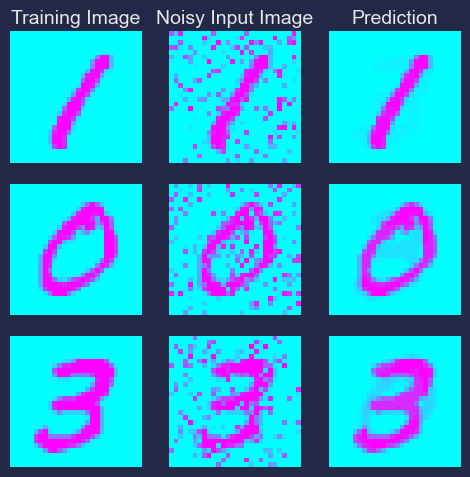

In [43]:
# plot demo samples

utils.plot(demo_train, demo_test, preds)

In [7]:
gc.collect()

691

## Evaluation

In [8]:
# define metric dicts and corruption levels (10 to 50%)

mse = {i:[] for i in range(10)}
psnr = {i:[] for i in range(10)}
ssim = {i:[] for i in range(10)}

corruption_levels = np.arange(0, 1.1, 0.1)

In [9]:
# train network and evaluate metrics for digits

for i in tqdm(range(0, 10, 2)):

    train_digit1 = train_data[i]
    train_digit2 = train_data[i+1]
    # preprocess data
    train_digit1_processed = [x.flatten() for x in train_digit1]
    train_digit1_processed = [x/255.0 for x in train_digit1_processed]
    train_digit1_processed = np.array(train_digit1_processed)

    train_digit2_processed = [x.flatten() for x in train_digit2]
    train_digit2_processed = [x/255.0 for x in train_digit2_processed]
    train_digit2_processed = np.array(train_digit2_processed)

    # instantiate model & train
    som = MiniSom(28, 28, 784, sigma=4,
              learning_rate=0.5, neighborhood_function='triangle')
    som.random_weights_init(np.append(train_digit1_processed, train_digit2_processed, axis=0))
    som.train(np.append(train_digit1_processed, train_digit2_processed, axis=0), 1000, random_order=True, verbose=True)

    # pattern recovery for varying corruption levels
    for corruption in corruption_levels:
        test_digit1 = [get_corrupted_input(x, corruption) for x in train_digit1_processed]
        test_digit2 = [get_corrupted_input(x, corruption) for x in train_digit2_processed]
        
        preds_digit1 = som.quantization(test_digit1)
        preds_digit2 = som.quantization(test_digit2)

        mse_digit1, psnr_digit1, ssim_digit1 = 0, 0, 0
        mse_digit2, psnr_digit2, ssim_digit2 = 0, 0, 0
        
        for j in range(len(train_digit1)):
            mse_digit1 += mean_squared_error(train_digit1_processed[j], preds_digit1[j])
            psnr_digit1 += peak_signal_noise_ratio(train_digit1_processed[j], preds_digit1[j].astype('int32'), data_range=255)
            ssim_digit1 += structural_similarity(train_digit1_processed[j], preds_digit1[j].astype('int32'), data_range=255)
        mse[i].append(mse_digit1/len(test_digit1))
        psnr[i].append(psnr_digit1/len(test_digit1))
        ssim[i].append(ssim_digit1/len(test_digit1))
        
        for j in range(len(train_digit2)):
            mse_digit2 += mean_squared_error(train_digit2_processed[j], preds_digit2[j])
            psnr_digit2 += peak_signal_noise_ratio(train_digit2_processed[j], preds_digit2[j].astype('int32'), data_range=255)
            ssim_digit2 += structural_similarity(train_digit2_processed[j], preds_digit2[j].astype('int32'), data_range=255)
        mse[i+1].append(mse_digit2/len(test_digit2))
        psnr[i+1].append(psnr_digit2/len(test_digit2))
        ssim[i+1].append(ssim_digit2/len(test_digit2))
        

  0%|          | 0/5 [00:00<?, ?it/s]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 3.814694196976922


 20%|██        | 1/5 [00:23<01:33, 23.45s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 5.564222871741851


 40%|████      | 2/5 [00:46<01:09, 23.13s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.834261133473808


 60%|██████    | 3/5 [01:07<00:44, 22.33s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.333361110286935


 80%|████████  | 4/5 [01:29<00:22, 22.20s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.783429152511634


100%|██████████| 5/5 [01:51<00:00, 22.36s/it]


In [10]:
gc.collect()

28

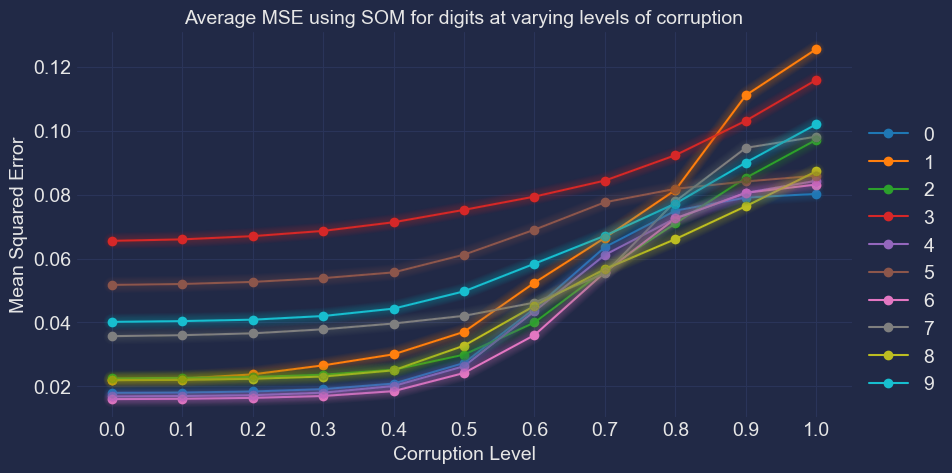

In [11]:
# plot mse

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, mse[i], label=i, marker='o')

plt.xticks(np.arange(0, 1.1, 0.1))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Mean Squared Error")
plt.title("Average MSE using SOM for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

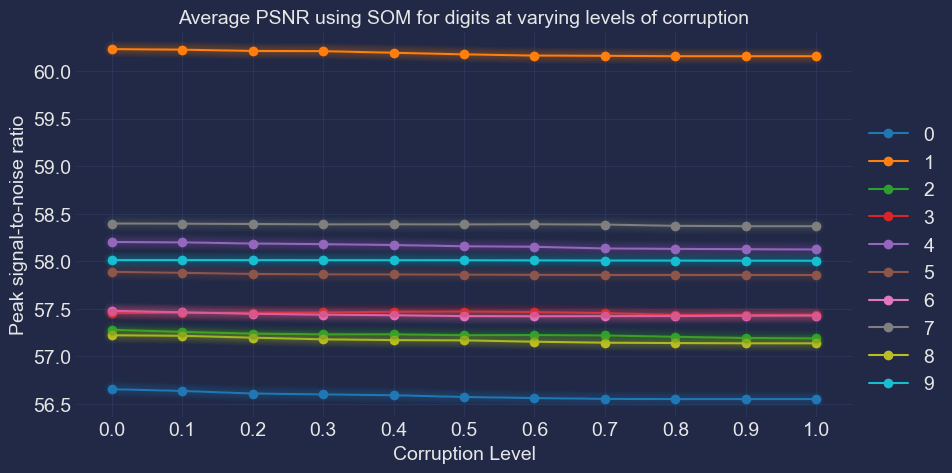

In [12]:
# plot psnr

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, psnr[i], label=i, marker='o')

plt.xticks(np.arange(0, 1.1, 0.1))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Peak signal-to-noise ratio")
plt.title("Average PSNR using SOM for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

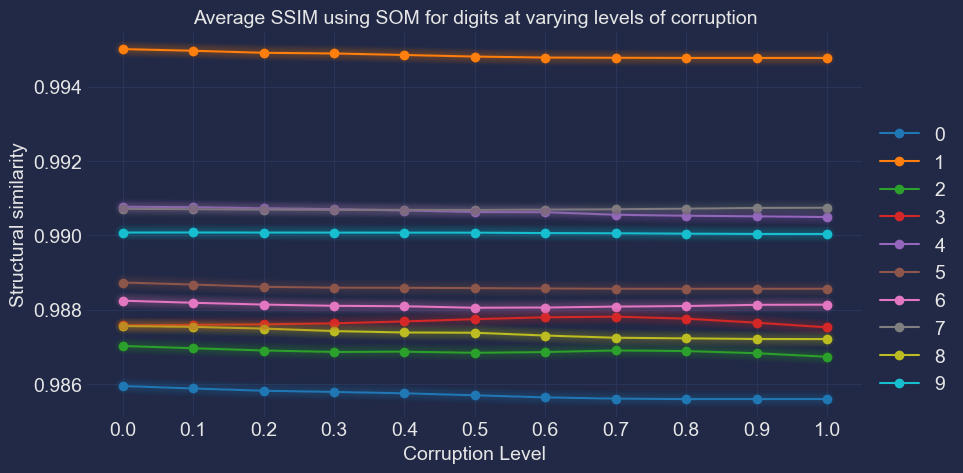

In [13]:
# plot ssim

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, ssim[i], label=i, marker='o')

plt.xticks(np.arange(0, 1.1, 0.1))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Structural similarity")
plt.title("Average SSIM using SOM for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

In [14]:
gc.collect()

20730

In [16]:
# save metrics for sharing

import pickle

with open('mse_som.pkl', 'wb') as f:
    pickle.dump(mse, f)
with open('psnr_som.pkl', 'wb') as f:
    pickle.dump(psnr, f)
with open('ssim_som.pkl', 'wb') as f:
    pickle.dump(ssim, f)